# モデルデプロイ

In [2]:
import pandas as pd
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor

import numba
import joblib

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as DataReader
import yfinance as yfin
yfin.pdr_override()

import talib

In [348]:
# n225 etf
df = pd.read_csv("NKKEI.csv", encoding="shift-jis")
df['Date'] = pd.to_datetime(df['日付'], format='%Y%m%d')
df['year'] = df['Date'].dt.year
df = df.sort_values(by='Date').set_index('Date')
display(df)

# dow
# df_dow = DataReader.get_data_yahoo('^DJI', start="2000-01-01")
# df_dow.to_pickle('dow.pkl')
df_dow = pd.read_pickle('dow.pkl')
display(df_dow)

# n225
# df_225 = DataReader.get_data_yahoo('^N225', start="2000-01-01")
# df_225.to_pickle('n225.pkl')
df_225 = pd.read_pickle('n225.pkl')
display(df_225)

# マージ
df = pd.merge(
    left=df.reset_index(), right=df_dow.reset_index(), how='left'
).merge(
    df_225.add_suffix("_n225").reset_index(), how='left'
).fillna(method='ffill').set_index('Date').dropna()
df.to_pickle('df_merge.pkl')
df

,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,5日平均.1,25日平均.1,year
Date,,,,,,,,,,,,,
2001-07-13,20010713,12510,12550,12300,12330,--,--,--,--,151130,--,--,2001
2001-07-16,20010716,12360,12380,12270,12320,--,--,--,--,79000,--,--,2001
2001-07-17,20010717,12140,12180,12110,12130,--,--,--,--,42250,--,--,2001
2001-07-18,20010718,12160,12160,11840,11860,--,--,--,--,128080,--,--,2001
2001-07-19,20010719,11880,11960,11850,11930,12114,--,--,--,489830,178058,--,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,29560,29630,29490,29620,29317,29489,29919.8,29542.4066,28669,46373.6,56782.6,2021
2021-12-24,20211224,29660,29715,29625,29660,29375,29455.4,29911.26,29669.1542,15139,38706,56499.92,2021
2021-12-27,20211227,29610,29645,29500,29525,29509,29410.4,29896.93,29560.6537,17324,29720,56657.84,2021


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,11453.480469,11542.410156,11442.820312,11497.120117,11497.120117,43620000
2000-01-03,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000
2000-01-04,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000
2000-01-05,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000
2000-01-06,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000
...,...,...,...,...,...,...
2021-12-22,35491.710938,35764.671875,35433.128906,35753.890625,35753.890625,281930000
2021-12-23,35782.421875,36060.988281,35782.421875,35950.558594,35950.558594,247420000
2021-12-27,35954.480469,36306.609375,35954.480469,36302.378906,36302.378906,244350000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,18937.449219,19187.609375,18937.449219,19002.859375,19002.859375,0
2000-01-05,19003.509766,19003.509766,18221.820312,18542.550781,18542.550781,0
2000-01-06,18574.009766,18582.740234,18168.269531,18168.269531,18168.269531,0
2000-01-07,18194.050781,18285.730469,18068.099609,18193.410156,18193.410156,0
2000-01-11,18246.099609,18887.560547,18246.099609,18850.919922,18850.919922,0
...,...,...,...,...,...,...
2021-12-24,28836.050781,28870.130859,28773.500000,28782.589844,28782.589844,35900000
2021-12-27,28786.330078,28805.279297,28658.820312,28676.460938,28676.460938,37500000
2021-12-28,28953.320312,29121.009766,28879.679688,29069.160156,29069.160156,47000000


,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,...,Low,Close,Adj Close,Volume,Open_n225,High_n225,Low_n225,Close_n225,Adj Close_n225,Volume_n225
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-13,20010713,12510,12550,12300,12330,--,--,--,--,151130,...,10432.599609,10539.059570,10539.059570,200390000.0,12417.559570,12444.559570,12294.040039,12355.150391,12355.150391,0.0
2001-07-16,20010716,12360,12380,12270,12320,--,--,--,--,79000,...,10446.599609,10472.120117,10472.120117,220170000.0,12408.389648,12408.389648,12263.450195,12343.370117,12343.370117,0.0
2001-07-17,20010717,12140,12180,12110,12130,--,--,--,--,42250,...,10438.660156,10606.389648,10606.389648,283640000.0,12215.469727,12224.709961,12102.940430,12128.570312,12128.570312,0.0
2001-07-18,20010718,12160,12160,11840,11860,--,--,--,--,128080,...,10480.879883,10569.830078,10569.830078,261170000.0,12121.410156,12135.309570,11847.730469,11892.580078,11892.580078,0.0
2001-07-19,20010719,11880,11960,11850,11930,12114,--,--,--,489830,...,10523.919922,10610.000000,10610.000000,235870000.0,11898.110352,11980.250000,11863.120117,11908.389648,11908.389648,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,29560,29630,29490,29620,29317,29489,29919.8,29542.4066,28669,...,35782.421875,35950.558594,35950.558594,247420000.0,28703.009766,28798.369141,28640.150391,28798.369141,28798.369141,43600000.0
2021-12-24,20211224,29660,29715,29625,29660,29375,29455.4,29911.26,29669.1542,15139,...,35782.421875,35950.558594,35950.558594,247420000.0,28836.050781,28870.130859,28773.500000,28782.589844,28782.589844,35900000.0
2021-12-27,20211227,29610,29645,29500,29525,29509,29410.4,29896.93,29560.6537,17324,...,35954.480469,36302.378906,36302.378906,244350000.0,28786.330078,28805.279297,28658.820312,28676.460938,28676.460938,37500000.0


In [39]:
df = pd.read_pickle('df_merge.pkl')

# 特徴量作成
def make_feature(df):
    df = df.assign(
        next_c2o = lambda df: df['始値'].shift(-1)/df['終値']-1,
        c2o = lambda df: df.next_c2o.shift(1)-1,

        o2c = lambda df: df['終値']/df['始値']-1,
        
        dow_o2c = lambda df: df.Close.shift(1).astype(float)/df.Open.shift(1).astype(float)-1,

        pre_o2c = lambda df: df.o2c.shift(1),
        pre_c2o = lambda df: df['始値'].shift(1)/df['終値'].shift(2)-1,

        pre_o2c2 = lambda df: df.pre_o2c.shift(1),
        pre_c2o2 = lambda df: df.pre_c2o.shift(1),

        pre_o2c3 = lambda df: df.pre_o2c.shift(1),
        pre_c2o3 = lambda df: df.pre_c2o.shift(1),

        trend = lambda df: df['終値'].shift(1)/df['終値'].shift(70)-1,
        trend2 = lambda df: df['終値'].shift(1)/df['終値'].shift(100)-1,
        trend3 = lambda df: df['終値'].shift(1)/df['終値'].shift(200)-1,
        trend_diff = lambda df: df.trend-df.trend.shift(30),
        
        diff_pre_c = lambda df: df['終値'].shift(1)/df['Close_n225'].shift(1)-1,
        diff_o = lambda df: df['始値'].shift(1)/df['Open_n225'].shift(1)-1,
        
        rsi180 = lambda df: (talib.RSI(df['終値'], timeperiod=180).shift(1)-50)/100,
    )
    return df

df = make_feature(df)
df

,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,...,pre_c2o2,pre_o2c3,pre_c2o3,trend,trend2,trend3,trend_diff,diff_pre_c,diff_o,rsi180
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-13,20010713,12510,12550,12300,12330,--,--,--,--,151130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-16,20010716,12360,12380,12270,12320,--,--,--,--,79000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002036,0.007444,NaN
2001-07-17,20010717,12140,12180,12110,12130,--,--,--,--,42250,...,NaN,-0.014388,NaN,NaN,NaN,NaN,NaN,-0.001893,-0.003900,NaN
2001-07-18,20010718,12160,12160,11840,11860,--,--,--,--,128080,...,0.002433,-0.003236,0.002433,NaN,NaN,NaN,NaN,0.000118,-0.006178,NaN
2001-07-19,20010719,11880,11960,11850,11930,12114,--,--,--,489830,...,-0.014610,-0.000824,-0.014610,NaN,NaN,NaN,NaN,-0.002740,0.003184,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,29560,29630,29490,29620,29317,29489,29919.8,29542.4066,28669,...,0.011783,0.004967,0.011783,-0.054662,0.034847,-0.034483,-0.114148,0.029332,0.030263,0.014968
2021-12-24,20211224,29660,29715,29625,29660,29375,29455.4,29911.26,29669.1542,15139,...,0.004772,-0.002714,0.004772,-0.049117,0.060888,-0.005039,-0.121825,0.028530,0.029857,0.017345
2021-12-27,20211227,29610,29645,29500,29525,29509,29410.4,29896.93,29560.6537,17324,...,0.005442,0.002030,0.005442,-0.055414,0.044734,-0.001347,-0.117408,0.030484,0.028574,0.017777


In [48]:
# 特徴量リスト
feature1 = ['pre_o2c', 'pre_c2o', 'trend', 'dow_o2c', 'diff_pre_c', 'rsi180']
feature2 = ['c2o', 'pre_o2c', 'trend', 'trend2', 'rsi180']

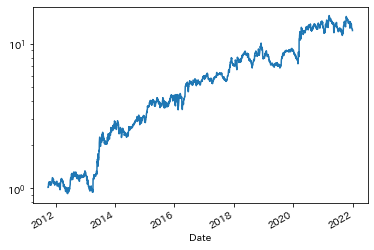

In [43]:
# Open 2 Close
model_o2c = Ridge(alpha=0.1)

X = df[feature1].fillna(0)
y = df.o2c

l = len(y)
ll = l//2

model_o2c.fit(X.iloc[:ll], y.iloc[:ll])
# joblib.dump(model_o2c, 'model_o2c.xz', compress=True)
# model_o2c = joblib.load('model_o2c.xz')

pred = model_o2c.predict(X)
df['pred1'] = pred

df = df.assign(
    exec1 = lambda df: ((df['終値'].shift(1)/1.005<df['始値'])&(df.pred1<0))|((df['終値'].shift(1)*1.005>df['始値'])&(df.pred1>0)),
    rate1 = lambda df: (df.o2c * df.pred1.apply(lambda x: 1 if x>0.000 else -1 if  x<-0.000 else 0)).apply(lambda x: 0 if x==0 else x-0.02/365) * 3 * df.exec1+1,
)

df.rate1.iloc[ll:].cumprod().plot()
plt.yscale('log')
plt.show()

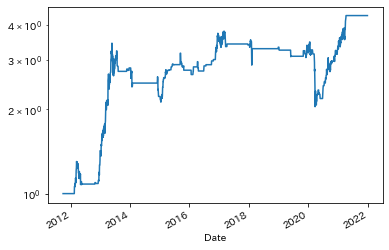

In [55]:
# Close 2 Open
model_c2o = Ridge(alpha=1.0)

X = df[feature2].fillna(0)
y = df.next_c2o

l = len(y)
ll = l//2

model_c2o.fit(X.iloc[:ll], y.iloc[:ll])
# joblib.dump(model_c2o, 'model_c2o.xz', compress=True)
# model_c2o = joblib.load('model_c2o.xz')

pred = model_c2o.predict(X)
df['pred2'] = pred

df = df.assign(
    exec2 = lambda df: True,#((df['終値']>df['始値']*1.005)&(df.pred2<0))|((df['終値']<df['始値']/1.005)&(df.pred2>0)),
    rate2 = lambda df: (df.next_c2o * df.pred2.apply(lambda x: 1 if x>0.0005 else -1 if  x<-0.0005 else 0)).apply(lambda x: 0 if x==0 else x-0.04*2/365) * df.exec2 * 3 + 1,
)

df.rate2.iloc[ll:].cumprod().plot()
plt.yscale('log')
plt.show()

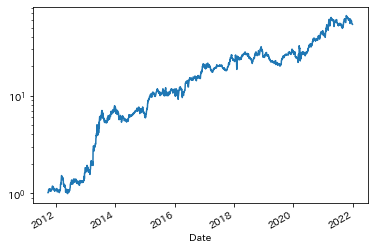

In [56]:
df.assign(
    rate = lambda df: df.rate1 + df.rate2 - 1
).rate.iloc[ll:].cumprod().plot()

plt.yscale('log')
plt.show()

評価期間のパフォーマンス


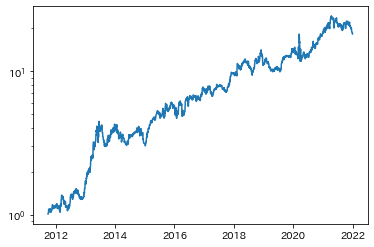

学習期間のパフォーマンス


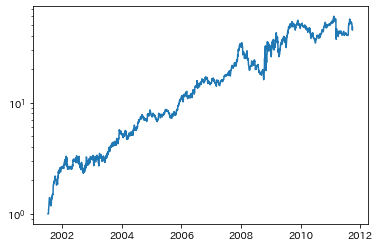

In [57]:
@numba.njit
def sim(rate1, pred1, exec1,rate2, pred2, exec2):
    returns  = np.zeros_like(rate1) + 1.0
    hold = False
    for i in range(rate1.size):
        # open
        if hold==False:
            if ((pred1[i]>0.0001)|(pred1[i]<-0.0001))&(exec1[i]):
                hold=True
                returns[i] = rate1[i]
        else:
            hold = False
        # close
        if hold==False:
            if ((pred2[i]>0.0004)|(pred2[i]<-0.0004))&(exec2[i]):
                hold=True
                returns[i] = rate2[i]
        else:
            hold = False
    return returns

print("評価期間のパフォーマンス")
df['returns'] = sim(df.rate1.values, df.pred1.values, df.exec1.values, df.rate2.values, df.pred2.values, df.exec2.values)
plt.plot(df.returns[ll:].cumprod())
plt.yscale('log')
plt.show()

print("学習期間のパフォーマンス")
df['returns'] = sim(df.rate1.values, df.pred1.values, df.exec1.values, df.rate2.values, df.pred2.values, df.exec2.values)
plt.plot(df.returns[:ll].cumprod())
plt.yscale('log')
plt.show()

In [392]:
len(df)

5014

In [393]:
(df.returns!=1).sum()

2553

# 実行アルゴリズム
- 寄り付き：
    - シグナルが出ていれば、前日終値で「指値」エントリー（前日終値よりも始値が有利な条件なら約定）
    - 当日の引けで成行クローズ
- 引け：
    - シグナルが出ていれば、当日始値で「逆指値」エントリー（当日始値よりも終値が不利な条件【=想定した方向に動いていたら】なら約定）
    - 翌日の寄付きで成行クローズ

In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor

import numba
import joblib

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as DataReader
import yfinance as yfin
yfin.pdr_override()

import json
import requests
import yaml
import configparser
from pywinauto import Desktop, Application, findwindows
from pywinauto.keyboard import SendKeys, send_keys
import time

import talib

from IPython.display import clear_output

In [2]:
# config 読み込み
ENV = 'prod' #prod or val

# config
config_ini = configparser.ConfigParser()
config_ini.read('..//config.ini', encoding='utf-8')
if ENV=='prod':
    number = config_ini.get('au', 'number_prod')
    pswrd = config_ini.get('au', 'pswrd_prod')
else:
    number = config_ini.get('au', 'number_val')
    pswrd = config_ini.get('au', 'pswrd_val')

th1 = 0.000
th2 = 0.0004

feature1 = ['pre_o2c', 'pre_c2o', 'trend', 'dow_o2c', 'diff_pre_c', 'rsi180']
feature2 = ['c2o', 'pre_o2c', 'trend', 'trend2']

model_o2c = joblib.load('model_o2c.xz')
# model_c2o = joblib.load('model_c2o.xz')

In [3]:
# 特徴量作成
def make_feature(df):
    df = df.assign(
        next_c2o = lambda df: df['始値'].shift(-1)/df['終値']-1,
        c2o = lambda df: df.next_c2o.shift(1)-1,

        o2c = lambda df: df['終値']/df['始値']-1,
        
        dow_o2c = lambda df: df.Close.shift(1).astype(float)/df.Open.shift(1).astype(float)-1,

        pre_o2c = lambda df: df.o2c.shift(1),
        pre_c2o = lambda df: df['始値'].shift(1)/df['終値'].shift(2)-1,

        pre_o2c2 = lambda df: df.pre_o2c.shift(1),
        pre_c2o2 = lambda df: df.pre_c2o.shift(1),

        pre_o2c3 = lambda df: df.pre_o2c.shift(1),
        pre_c2o3 = lambda df: df.pre_c2o.shift(1),

        trend = lambda df: df['終値'].shift(1)/df['終値'].shift(70)-1,
        trend2 = lambda df: df['終値'].shift(1)/df['終値'].shift(100)-1,
        trend3 = lambda df: df['終値'].shift(1)/df['終値'].shift(200)-1,
        trend_diff = lambda df: df.trend-df.trend.shift(30),
        
        diff_pre_c = lambda df: df['終値'].shift(1)/df['Close_n225'].shift(1)-1,
        diff_o = lambda df: df['始値'].shift(1)/df['Open_n225'].shift(1)-1,
        
        rsi180 = lambda df: (talib.RSI(df['終値'], timeperiod=180).shift(1)-50)/100,
    )
    return df


# データロード
def load_data():
    df_dow = DataReader.get_data_yahoo('^DJI', start="2010-01-01")
    df = DataReader.get_data_yahoo('1320.T', start="2010-01-01")
    df_225 = DataReader.get_data_yahoo('^N225', start="2010-01-01")
    df.columns = ['始値', '高値', '安値', '終値', '調整済み終値', '出来高']
    df = df.query("始値!=0")
    
    df = pd.merge(
        left=df.reset_index(), right=df_dow.reset_index(), how='left'
    ).merge(
        df_225.add_suffix("_n225").reset_index(), how='left'
    ).fillna(method='ffill').set_index('Date').dropna()
    
    df = make_feature(df)

    X1 = df[feature1].fillna(0)
    X2 = df[feature2].fillna(0)
    
    df['pred1'] = model_o2c.predict(X1)
#     df['pred2'] = model_c2o.predict(X2)

    df['signal1'] = df['pred1'].apply(lambda x: "buy" if x>th1 else "sell" if x<-th1 else None)
#     df['signal2'] = df['pred2'].apply(lambda x: "buy" if x>th2 else "sell" if x<-th2 else None)
    
    return df



# 初期化
def get_token():  # トークンを取得する。取得する度・またはkabuステーション再起動の度に変わる。
    url = 'http://localhost:'+number+'/kabusapi/token'
    headers = {'content-type': 'application/json'}
    payload = json.dumps(
        {'APIPassword': pswrd,}
    ).encode('utf8')
    response = requests.post(url, data=payload, headers=headers)
    return json.loads(response.text)['Token']

# 新規注文
def send_orders(token, symbol, qty, side, price):
    url = 'http://localhost:'+number+'/kabusapi/sendorder'
    headers = {'content-type': 'application/json', 'X-API-KEY': token}
    payload = json.dumps(
        {
          "Password": pswrd,
          "Symbol": symbol,
          "Exchange": 1,#1: 東証
          "SecurityType": 1,#1: 株式
          "Side": side,#1: 売り, #2: 買い
          "CashMargin": 2,#1: 現物, 2: 新規, 3: 返済
          "MarginTradeType": 1,#1 制度信用, 2 一般信用（長期）, 3: 一般信用（デイトレ）
          "DelivType": 0,#0: 指定なし, 1: 自動振替, 2: お預り金
          "AccountType": 4,#2: 一般, 4: 特定, 12: 法人,
          "Qty": qty,#注文数量
          "FrontOrderType": 21,
            #10: 成行->0, 13: 寄成（前場）->0, 14: 寄成（後場）->0, 15: 引成（前場）->0, 16-: 引成（後場）->0
            #17: IOC成行->0, 20: 指値->発注したい金額, 21: 寄指（前場）->発注したい金額, 22: 寄指（後場）-> 発注したい金額
            #23: 引指（前場）->発注したい金額, 24: 引指（後場）->発注したい金額, 25: 不成（前場）->発注したい金額
            #26: 不成（後場）->発注したい金額, 27: IOC指値->発注したい金額, 30: 逆指値->発注したい金額
          "Price": price,
          "ExpireDay": 0,#yyyyMMdd形式。「0」を指定すると、kabuステーション上の発注画面の「本日」に対応する日付として扱います。
        }
    ).encode('utf8')

    response = requests.post(url, data=payload, headers=headers)
    res = json.loads(response.text)
    return res

# 注文履歴
def check_orders(token):
    url = 'http://localhost:'+number+'/kabusapi/orders'
    response = requests.get(url, headers={'X-API-KEY': token,})
    orders = json.loads(response.text)
        
    return orders

# 建玉確認
def check_positions(token):
    url = 'http://localhost:'+number+'/kabusapi/positions'
    response = requests.get(url, headers={'X-API-KEY': token,})
    positions = json.loads(response.text)
    return positions

# 決済注文
def send_orders_close(token, symbol, qty, side, closePositions):
    url = 'http://localhost:'+number+'/kabusapi/sendorder'
    headers = {'content-type': 'application/json', 'X-API-KEY': token}
    payload = json.dumps(
        {
          "Password": pswrd,
          "Symbol": symbol,
          "Exchange": 1,#1: 東証
          "SecurityType": 1,#1: 株式
          "Side": side,#1: 売り, #2: 買い
          "CashMargin": 3,#1: 現物, 2: 新規, 3: 返済
          "MarginTradeType": 1,#1 制度信用, 2 一般信用（長期）, 3: 一般信用（デイトレ）
          "DelivType": 2,#0: 指定なし, 1: 自動振替, 2: お預り金
          "AccountType": 4,#2: 一般, 4: 特定, 12: 法人,
          "Qty": qty,#注文数量
#           "ClosePositionOrder": 0,
          "ClosePositions": closePositions,
          "FrontOrderType": 16,
            #10: 成行->0, 13: 寄成（前場）->0, 14: 寄成（後場）->0, 15: 引成（前場）->0, 16-: 引成（後場）->0
            #17: IOC成行->0, 20: 指値->発注したい金額, 21: 寄指（前場）->発注したい金額, 22: 寄指（後場）-> 発注したい金額
            #23: 引指（前場）->発注したい金額, 24: 引指（後場）->発注したい金額, 25: 不成（前場）->発注したい金額
            #26: 不成（後場）->発注したい金額, 27: IOC指値->発注したい金額, 30: 逆指値->発注したい金額
          "Price": 0,
          "ExpireDay": 0,#yyyyMMdd形式。「0」を指定すると、kabuステーション上の発注画面の「本日」に対応する日付として扱います。
        }
    ).encode('utf8')

    response = requests.post(url, data=payload, headers=headers)
    res = json.loads(response.text)
    return res

- kabu-station起動 @ 8:30
- ポジションの確認
    - ポジションあり（前日未決済）　→　決済注文の実行 & エラーメッセージ
- シグナル確認
    - buy or sell　→　注文の実行
- ポジションの確認 @ 9:30
    - ポジションあり　→　決済注文の実行
- kabu-station終了

In [5]:
df = load_data()
display(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,始値,高値,安値,終値,調整済み終値,出来高,Open,High,Low,Close,...,pre_c2o3,trend,trend2,trend3,trend_diff,diff_pre_c,diff_o,rsi180,pred1,signal1
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-04,10402.0,10402.0,10402.0,10402.0,10402.0,0,10273.120117,10273.120117,9998.030273,10002.179688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000242,sell
2010-02-05,10120.0,10160.0,10080.0,10120.0,10120.0,281310,10003.690430,10031.959961,9835.089844,10012.230469,...,NaN,NaN,NaN,NaN,NaN,0.004444,-0.003117,NaN,0.000640,buy
2010-02-08,10030.0,10100.0,9990.0,10010.0,10010.0,174880,10005.429688,10028.559570,9904.089844,9908.389648,...,NaN,NaN,NaN,NaN,NaN,0.006255,-0.004166,NaN,-0.001284,sell
2010-02-09,9950.0,10000.0,9920.0,9990.0,9990.0,90540,9910.280273,10139.429688,9910.059570,10058.639648,...,-0.027110,NaN,NaN,NaN,NaN,0.005846,0.002251,NaN,-0.000073,sell
2010-02-10,10080.0,10100.0,10010.0,10040.0,10040.0,102000,10055.459961,10085.540039,9962.959961,10038.379883,...,-0.008893,NaN,NaN,NaN,NaN,0.005749,0.007431,NaN,-0.001218,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,28130.0,28435.0,27965.0,28375.0,28375.0,78725,34701.691406,34896.671875,34229.550781,34265.371094,...,-0.015282,-0.009349,0.008460,-0.051078,-0.022743,0.030140,0.029691,0.004591,-0.000752,sell
2022-01-24,28070.0,28465.0,28030.0,28430.0,28430.0,50564,34070.609375,34420.988281,33150.328125,34364.500000,...,-0.002827,-0.032561,0.000529,-0.066612,-0.069761,0.030984,0.026479,0.001996,-0.000726,sell
2022-01-25,28285.0,28310.0,27720.0,27965.0,27965.0,142990,34186.640625,34591.039062,33545.519531,34297.730469,...,-0.016777,-0.021679,0.005304,-0.061716,-0.073659,0.030507,0.029772,0.002598,-0.001542,sell


In [ ]:
############################################## 8:30 ##############################################
# kabu-station起動
app = Application().start("C:\\Program Files\Internet Explorer\iexplore.exe http://download.r10.kabu.co.jp/kabustation/KabuStation.application")
time.sleep(10)

app = app.connect(title_re="ログイン")# 起動したウィンドウにフォーカスを当てる
btn = app['ログイン']
btn.set_focus()
time.sleep(10)

send_keys(pswrd)# パスワードの入力＆Enter
time.sleep(5)
send_keys("{ENTER}")
time.sleep(15)

token = get_token()# 初期化
symbol = 1320


# 建玉確認
positions = check_positions(token)

# 決済注文
if len(positions)>0:
    closePositions = []
    for pos in positions:
        if pos['Symbol']==symbol:
            closePositions.append({"HoldID": pos['ExecutionID'], "Qty": int(pos['LeavesQty'])})
            break
    
    close_side = '1' if pos['Side']=='2' else '2'
if len(closePositions)>0:
    res = send_orders_close(token, symbol=1320, qty=1, side=close_side, closePositions=closePositions)
    print(res)

# シグナル確認
df = load_data()
display(df)

# 新規注文
signal = df.signal1.iloc[-1]
side = '2' if signal=='buy' else '1'
qty = 5
price = int(df['終値'].iloc[-1] * 1.005) if signal=='buy' else int(df['終値'].iloc[-1] / 1.005)
res = send_orders(token, symbol, qty, side, price)
print(res)


############################################## 9:10 ##############################################
time.sleep(60*30)

# 建玉確認
positions = check_positions(token)

# 決済注文
closePositions = []
if len(positions)>0:
    for pos in positions:
        if pos['Symbol']==symbol:
            closePositions.append({"HoldID": pos['ExecutionID'], "Qty": int(pos['LeavesQty'])})
            break
    
    close_side = '1' if side=='2' else '2'
if len(closePositions)>0:
    res = send_orders_close(token, symbol=symbol, qty=qty, side=close_side, closePositions=closePositions)
    print(res)

# kabu-station終了
app.kill()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,始値,高値,安値,終値,調整済み終値,出来高,Open,High,Low,Close,...,pre_c2o3,trend,trend2,trend3,trend_diff,diff_pre_c,diff_o,rsi180,pred1,signal1
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-04,10402.0,10402.0,10402.0,10402.0,10402.0,0,10273.120117,10273.120117,9998.030273,10002.179688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000242,sell
2010-02-05,10120.0,10160.0,10080.0,10120.0,10120.0,281310,10003.690430,10031.959961,9835.089844,10012.230469,...,NaN,NaN,NaN,NaN,NaN,0.004444,-0.003117,NaN,0.000640,buy
2010-02-08,10030.0,10100.0,9990.0,10010.0,10010.0,174880,10005.429688,10028.559570,9904.089844,9908.389648,...,NaN,NaN,NaN,NaN,NaN,0.006255,-0.004166,NaN,-0.001284,sell
2010-02-09,9950.0,10000.0,9920.0,9990.0,9990.0,90540,9910.280273,10139.429688,9910.059570,10058.639648,...,-0.027110,NaN,NaN,NaN,NaN,0.005846,0.002251,NaN,-0.000073,sell
2010-02-10,10080.0,10100.0,10010.0,10040.0,10040.0,102000,10055.459961,10085.540039,9962.959961,10038.379883,...,-0.008893,NaN,NaN,NaN,NaN,0.005749,0.007431,NaN,-0.001218,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,28130.0,28435.0,27965.0,28375.0,28375.0,78725,34701.691406,34896.671875,34229.550781,34265.371094,...,-0.015282,-0.009349,0.008460,-0.051078,-0.022743,0.030140,0.029691,0.004591,-0.000752,sell
2022-01-24,28070.0,28465.0,28030.0,28430.0,28430.0,50564,34070.609375,34420.988281,33150.328125,34364.500000,...,-0.002827,-0.032561,0.000529,-0.066612,-0.069761,0.030984,0.026479,0.001996,-0.000726,sell
2022-01-25,28285.0,28310.0,27720.0,27965.0,27965.0,142990,34186.640625,34591.039062,33545.519531,34297.730469,...,-0.016777,-0.021679,0.005304,-0.061716,-0.073659,0.030507,0.029772,0.002598,-0.001542,sell


{'Code': 4002004, 'Message': 'トリガチェックエラー - 詳細はkabuSログファイルを確認してください'}
